In [13]:
dirname = 'data/Stock_Returns/Original'
filename = 'stocks.csv'
timeframe = 9

import os.path
import csv

rows = []
with open(os.path.join(dirname, filename), 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        rows.append(row)
#print(rows)

In [14]:
# skip = 0 # SPY.csv
skip = 1 # Original/stocks.csv

cumulative_returns = [1] * len(rows)
for start in range(len(rows)):
    # skip first row
    if (skip):
        skip = 0
        continue
    for offset in range(timeframe):
        if (start+offset >= len(rows)):
            break
        multiplier = 1+float(rows[start+offset][2])
        cumulative_returns[start] *= multiplier
#cumulative_returns

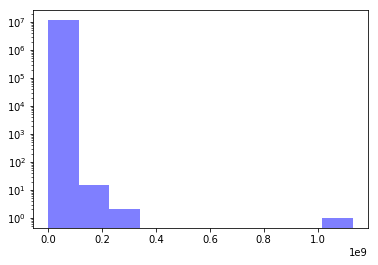

In [16]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
num_bins = 10
n, bins, patches = plt.hist(cumulative_returns, num_bins, facecolor='blue', alpha=0.5, log = 'y')
plt.show()

In [69]:
# skip = 0 # SPY.csv
skip = 1 # Original/stocks.csv
timeframe = 30

rows2 = rows[2000000:2100000]
cumulative_returns = [1] * len(rows2)
for start in range(len(rows2)):
    # skip first row
    if (skip):
        skip = 0
        continue
    for offset in range(timeframe):
        if (start+offset >= len(rows2)):
            break
        multiplier = 1+float(rows[start+offset][2])
        cumulative_returns[start] *= multiplier
#cumulative_returns


In [70]:
print(cumulative_returns[5000:5100])

[1.0729962024620479, 1.0815599768512882, 1.068833542758615, 1.0706526628524085, 1.0773604855301244, 1.0836768826091785, 1.0741968219383995, 1.080092364416267, 1.06147698219183, 1.0645904944731783, 1.065412699008344, 1.056002974023713, 1.0428178967236874, 1.0397774987359496, 1.030495642701347, 1.0088388988765553, 1.0292113635388864, 1.0842731986217147, 1.0913112652657442, 1.0857978735237899, 1.0801072525412432, 1.0611927139322166, 1.047756083578799, 1.020932951291384, 1.0172754599025091, 1.0255174273106324, 1.0302143478605919, 1.0030549818877483, 0.9756450489051841, 0.9123711285927563, 0.9289641322788389, 0.931538912145069, 0.9422513974653771, 0.9513832925257363, 0.9378841822634075, 0.939935345248695, 0.9355903304489951, 0.9279144313726787, 0.956490191975465, 0.9519682618701814, 0.9486303368224162, 0.9557573827429361, 0.9629656897108435, 0.9688530590441964, 0.9761345266042227, 0.9864865451842955, 0.9776580459165028, 0.9732013439296224, 0.9569340125382669, 0.9662806418511722, 0.977078627

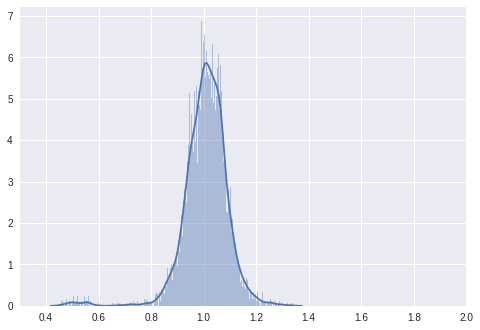

In [71]:
import seaborn as sns, numpy as np
sns.set();
ax = sns.distplot(np.array(cumulative_returns[:10000]), bins=500)
ax.set_xlim(0.3,2)
plt.show()

In [72]:
neg = 0
pos = 0
for ret in cumulative_returns:
    if ret <= 1:
        neg+=1
    else:
        pos+=1
print("neg: {} pos: {}".format(neg, pos))

neg: 41701 pos: 58299


In [106]:
import sqlite3
import glob
import re
import getReturns
mode = 1
conn = sqlite3.connect('Database/stocks.db')
form10KPath = '../GROUP_SHARED/data/10K/10-X_C/'
cikTickerPath = '../GROUP_SHARED/data/10K/10-X_C/cikTicker.txt'
with open(cikTickerPath) as cikfile:
    cikTicker = cikfile.read()  
cikTicker = cikTicker.replace('\n', '')
cikTicker = cikTicker.replace('"', '')
cikTicker = cikTicker.replace('"', '')
cikTicker = cikTicker[2:-2].split('}, {')
cikdict = dict(s.split(', ') for s in cikTicker)
def parseTxtName(txt):
    txt = os.path.basename(txt)
    pattern = "edgar_data_(.*?)_"
    m = re.search(pattern, txt)
    if m:
        cik = m.group(1)
    pattern = "(\d{8})_"
    m = re.search(pattern, txt)
    if m:
        date = m.group(1)
    date = '{}-{}-{}'.format(date[0:4], date[4:6], date[6:])
    return cik, date
def isPos(txt, cikdict, mode): 
    cik, date = parseTxtName(txt)
    if cik in cikdict:
        if (mode == 0):
            ret = getReturns.getRets(conn, cikdict[cik], date, 4) 
        elif (mode == 1):
            ret = getReturns.getTotalRet(conn, cikdict[cik], date, 30)
        elif (mode == 2):
            stock_ret = getReturns.getTotalRet(conn, cikdict[cik], dateSubtract(date, 4), 9)
            spy_ret = getReturns.getTotalRet(conn, 'SPY', dateSubtract(date, 4), 9)
            alpha = getReturns.getRets(conn, cikdict[cik], date)[0][3]
            ret = stock_ret - spy_ret * alpha
            print("stock_ret = {}".format(stock_ret))
            print("spy_ret = {}".format(spy_ret))
            print("ret/cum. alpha = {}".format(ret))
    else:
        #print('not in cikdict')
        raise Exception('Not in cikDict')
    if (mode == 0):
        if (len(ret) != 0): 
            return(np.sign(ret[0][3])==1.0)
        else:            
            print('exception')
            raise Exception('Query failed')
    elif (mode == 1):
        if (ret == 0.0):
            return 0
        elif (ret < -1.0):
            return -2
        elif (ret < -0.1):
            return -1
        elif (ret < 0.1):
            return 1
        elif (ret < 1.0):
            return 2
        else:
            return 3
    elif (mode == 2):
        if (ret < -3.0):
            return -2
        elif (ret < -0.5):
            return -1
        elif (ret < 0.5):
            return 0
        elif (ret < 3.0):
            return 1
        else:
            return 2
"""
quarters = ['2013/QTR2', '2013/QTR3', '2013/QTR4', 
            '2012/QTR1', '2012/QTR2', '2012/QTR3', '2012/QTR4', 
            '2011/QTR1', '2011/QTR2', '2011/QTR3', '2011/QTR4', 
            '2010/QTR1', '2010/QTR2', '2010/QTR3', '2010/QTR4', 
            '2009/QTR1', '2009/QTR2', '2009/QTR3', '2009/QTR4', 
            '2008/QTR1', '2008/QTR2', '2008/QTR3', '2008/QTR4', 
            '2007/QTR1', '2007/QTR2', '2007/QTR3', '2007/QTR4', 
            '2006/QTR1', '2006/QTR2', '2006/QTR3', '2006/QTR4', 
            '2005/QTR1', '2005/QTR2', '2005/QTR3', '2005/QTR4', 
            '2004/QTR1', '2004/QTR2', '2004/QTR3', '2004/QTR4', 
            '2003/QTR1', '2003/QTR2', '2003/QTR3', '2003/QTR4', 
            '2002/QTR1', '2002/QTR2', '2002/QTR3', '2002/QTR4', 
            '2001/QTR1', '2001/QTR2', '2001/QTR3', '2001/QTR4', 
            '2000/QTR1', '2000/QTR2', '2000/QTR3', '2000/QTR4', 
            '1999/QTR1', '1999/QTR2', '1999/QTR3', '1999/QTR4', 
            '1998/QTR1', '1998/QTR2', '1998/QTR3', '1998/QTR4', 
            '1997/QTR1', '1997/QTR2', '1997/QTR3', '1997/QTR4', 
            '1996/QTR1', '1996/QTR2', '1996/QTR3', '1996/QTR4', 
            '1995/QTR1', '1995/QTR2', '1995/QTR3', '1995/QTR4',
            '1994/QTR1', '1994/QTR2', '1994/QTR3', '1994/QTR4']
"""
quarters = ['2012/QTR1']
pos =0
neg =0
unsupervised =0
neutral = 0
for quarter in quarters:
    dirname = os.path.join(form10KPath, quarter)
    txt_files = glob.glob(os.path.join(dirname, '*.txt'))
    for txt in txt_files:
        try:
            result = isPos(txt, cikdict, mode)
            if (result == 0):
                unsupervised+=1
            elif (result > 1):
                pos+=1
            elif (result == 1):
                neutral += 1
            else:
                neg+=1
        except Exception as ex:
            #print(ex)
            continue

In [107]:
print("unsupervised: {} neutral: {} neg: {} pos: {}".format(unsupervised, neutral, neg, pos))

unsupervised: 5062 neutral: 1201 neg: 150 pos: 240
